## 三、示例应用

### 1 信号前沿分析

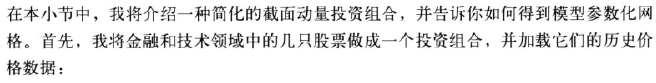

In [59]:
Image(filename="py35_picture\Signal Frontier Analysis.png")

In [52]:
names = ['AAPL', 'GOOG', 'MSFT', 'DELL', 'GS', 'MS', 'BAC', 'C']
def get_px(stock, start, end):
    return web.get_data_yahoo(stock, start, end)['Adj Close']
px = pd.DataFrame({n: get_px(n, None, None) for n in names})

In [53]:
plt.close('all')

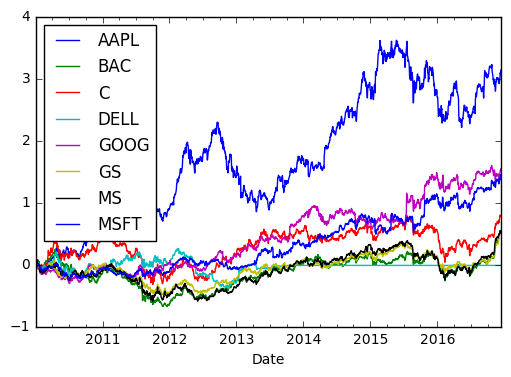

In [54]:
# 绘制每只股票的累计收益
px = px.asfreq('B').fillna(method='pad')
rets = px.pct_change()
((1 + rets).cumprod() - 1).plot()

In [55]:
# 计算特定回顾期的动量，然后按降序排列并标准化
def calc_mom(price, lookback, lag):
    mom_ret = price.shift(lag).pct_change(lookback)
    ranks = mom_ret.rank(axis=1, ascending=False)
    demeaned = ranks.subtract(ranks.mean(axis=1), axis=0)
    return demeaned.divide(demeaned.std(axis=1), axis=0)

In [56]:
# 对策略进行事后检验的函数：通过指定回顾期和持有期（买卖之间的日期）计算投资组合整体的夏普比率
compound = lambda x : (1 + x).prod() - 1
daily_sr = lambda x: x.mean() / x.std()

def strat_sr(prices, lb, hold):
    # 计算投资组合权重
    freq = '%dB' % hold
    port = calc_mom(prices, lb, lag=1)

    daily_rets = prices.pct_change()

    # 计算投资组合收益
    port = port.shift(1).resample(freq, how='first')
    returns = daily_rets.resample(freq, how=compound)
    port_rets = (port * returns).sum(axis=1)

    return daily_sr(port_rets) * np.sqrt(252 / hold)

In [57]:
# 通过价格数据以及一对参数组合调用该函数将会得到一个标量值
strat_sr(px, 70, 30)

D:\software\Anaconda3\lib\site-packages\ipykernel\__main__.py:12: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).first()
D:\software\Anaconda3\lib\site-packages\ipykernel\__main__.py:13: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...)..apply(<func>)


-0.21832310989332854

In [61]:
# 对参数网格（即多对参数组合）应用start_sr函数
from collections import defaultdict

lookbacks = range(20, 90, 5)
holdings = range(20, 90, 5)
dd = defaultdict(dict)
for lb in lookbacks:
    for hold in holdings:
        dd[lb][hold] = strat_sr(px, lb, hold)

ddf = pd.DataFrame(dd)
ddf.index.name = 'Holding Period'
ddf.columns.name = 'Lookback Period'

D:\software\Anaconda3\lib\site-packages\ipykernel\__main__.py:12: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).first()
D:\software\Anaconda3\lib\site-packages\ipykernel\__main__.py:13: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...)..apply(<func>)


In [62]:
# 结果图形化
import matplotlib.pyplot as plt

def heatmap(df, cmap=plt.cm.gray_r):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    axim = ax.imshow(df.values, cmap=cmap, interpolation='nearest')
    ax.set_xlabel(df.columns.name)
    ax.set_xticks(np.arange(len(df.columns)))
    ax.set_xticklabels(list(df.columns))
    ax.set_ylabel(df.index.name)
    ax.set_yticks(np.arange(len(df.index)))
    ax.set_yticklabels(list(df.index))
    plt.colorbar(axim)

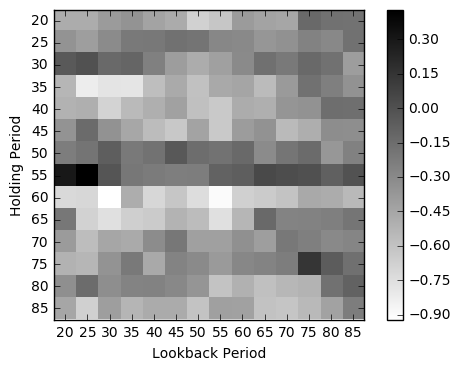

In [63]:
heatmap(ddf) # 传入事后检验结果

### 2 期货合约转仓

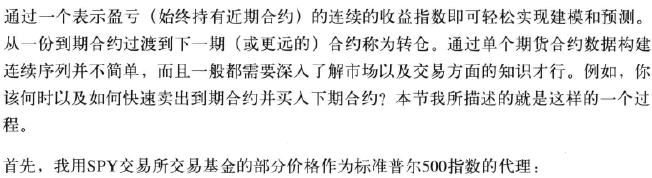

In [87]:
Image(filename="py35_picture\Future Contract Rolling.png")

In [70]:
pd.options.display.max_rows = 10

In [71]:
import pandas.io.data as web
# Approximate price of S&P 500 index
px = web.get_data_yahoo('SPY')['Adj Close'] * 10
px

D:\software\Anaconda3\lib\site-packages\pandas\io\data.py:35: FutureWarning: 
The pandas.io.data module is moved to a separate package (pandas-datareader) and will be removed from pandas in a future version.
After installing the pandas-datareader package (https://github.com/pydata/pandas-datareader), you can change the import ``from pandas.io import data, wb`` to ``from pandas_datareader import data, wb``.
  FutureWarning)


Date
2010-01-04     987.93254
2010-01-05     990.54769
2010-01-06     991.24509
2010-01-07     995.42943
2010-01-08     998.74198
                 ...    
2016-12-08    2251.49994
2016-12-09    2265.09995
2016-12-12    2262.50000
2016-12-13    2277.59995
2016-12-14    2258.80005
Name: Adj Close, dtype: float64

In [73]:
# 放入两份标准普尔500指数期货合约及其到期日期
from datetime import datetime
expiry = {'ESU2': datetime(2012, 9, 21),
          'ESZ2': datetime(2012, 12, 21)}
expiry = pd.Series(expiry).order()

D:\software\Anaconda3\lib\site-packages\ipykernel\__main__.py:4: FutureWarning: order is deprecated, use sort_values(...)


In [74]:
expiry

ESU2   2012-09-21
ESZ2   2012-12-21
dtype: datetime64[ns]

In [76]:
# 用Yahoo！Finance的价格以及一个随机漫步和一些噪声来模拟这两份合约的未来的走势
np.random.seed(12347)
N = 200
walk = (np.random.randint(0, 200, size=N) - 100) * 0.25
perturb = (np.random.randint(0, 20, size=N) - 10) * 0.25
walk = walk.cumsum()

rng = pd.date_range(px.index[0], periods=len(px) + N, freq='B')
near = np.concatenate([px.values, px.values[-1] + walk])
far = np.concatenate([px.values, px.values[-1] + walk + perturb])
prices = pd.DataFrame({'ESU2': near, 'ESZ2': far}, index=rng)

In [77]:
prices.tail() # price中有关于这两个合约的时间序列

,ESU2,ESZ2
2017-06-20,2288.05005,2289.80005
2017-06-21,2274.30005,2276.55005
2017-06-22,2282.30005,2284.05005
2017-06-23,2298.80005,2298.05005
2017-06-26,2278.80005,2276.55005


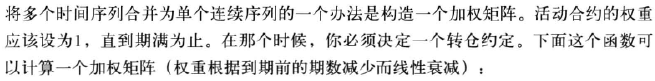

In [88]:
Image(filename="py35_picture\Future Contract Rolling 2.png")

In [80]:
def get_roll_weights(start, expiry, items, roll_periods=5):
    # start : first date to compute weighting DataFrame
    # expiry : Series of ticker -> expiration dates
    # items : sequence of contract names

    dates = pd.date_range(start, expiry[-1], freq='B')
    weights = pd.DataFrame(np.zeros((len(dates), len(items))),
                        index=dates, columns=items)

    prev_date = weights.index[0]
    for i, (item, ex_date) in enumerate(expiry.iteritems()):
        if i < len(expiry) - 1:
            weights.ix[prev_date:ex_date - pd.offsets.BDay(), item] = 1
            roll_rng = pd.date_range(end=ex_date - pd.offsets.BDay(),
                                     periods=roll_periods + 1, freq='B')

            decay_weights = np.linspace(0, 1, roll_periods + 1)
            weights.ix[roll_rng, item] = 1 - decay_weights
            weights.ix[roll_rng, expiry.index[i + 1]] = decay_weights
        else:
            weights.ix[prev_date:, item] = 1

        prev_date = ex_date

    return weights

In [81]:
weights = get_roll_weights('6/1/2012', expiry, prices.columns)
weights.ix['2012-09-12':'2012-09-21']

,ESU2,ESZ2
2012-09-12,1.0,0.0
2012-09-13,1.0,0.0
2012-09-14,0.8,0.2
2012-09-17,0.6,0.4
2012-09-18,0.4,0.6
2012-09-19,0.2,0.8
2012-09-20,0.0,1.0
2012-09-21,0.0,1.0


In [82]:
# 转仓期货收益就是合约收益的加权和
rolled_returns = (prices.pct_change() * weights).sum(1)

### 3 移动相关系数与线性回归

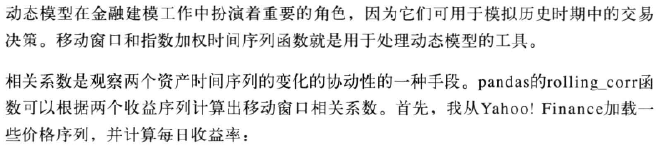

In [84]:
Image(filename="py35_picture\Rolling Correlation and Linear Regression.png")

In [64]:
aapl = web.get_data_yahoo('AAPL', '2000-01-01')['Adj Close']
msft = web.get_data_yahoo('MSFT', '2000-01-01')['Adj Close']

aapl_rets = aapl.pct_change()
msft_rets = msft.pct_change()

In [65]:
plt.figure()

D:\software\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: FutureWarning: pd.rolling_corr is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=250).corr(other=<Series>)
  if __name__ == '__main__':


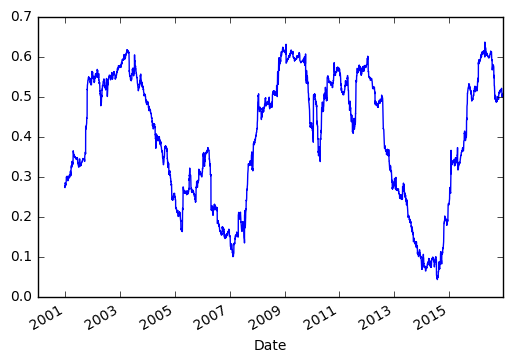

In [66]:
pd.rolling_corr(aapl_rets, msft_rets, 250).plot()

In [67]:
plt.figure()

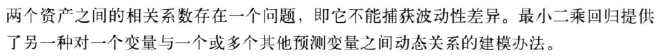

In [86]:
Image(filename="py35_picture\Rolling Correlation and Linear Regression 2.png")

In [83]:
model = pd.ols(y=aapl_rets, x={'MSFT': msft_rets}, window=250)
model.beta[:5]

D:\software\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: FutureWarning: The pandas.stats.ols module is deprecated and will be removed in a future version. We refer to external packages like statsmodels, see some examples here: http://statsmodels.sourceforge.net/stable/regression.html
  if __name__ == '__main__':


,MSFT,intercept
Date,,
2000-12-28,0.429020,-0.002113
2000-12-29,0.421102,-0.001796
2001-01-02,0.420595,-0.001839
2001-01-03,0.433291,-0.001289
2001-01-04,0.432771,-0.001307


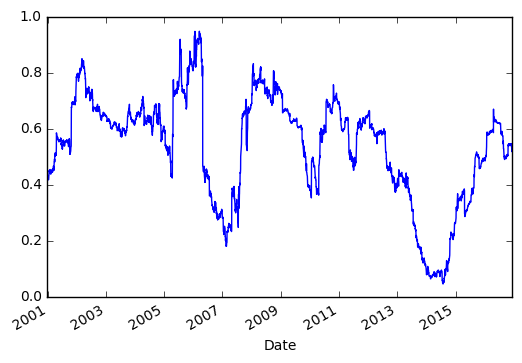

In [69]:
model.beta['MSFT'].plot()

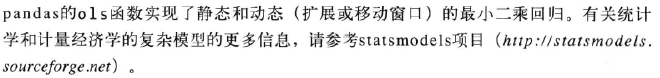

In [85]:
Image(filename="py35_picture\Rolling Correlation and Linear Regression 3.png")